# Plotting the results with basemap
This notebook is similar to [plot_results.ipynb](./16-plot-results.ipynb), except that it uses the [matplotlib basemap](https://matplotlib.org/basemap/) module to generate the plots. 
Hence all the details concerning the netCDF reading will not be repeated here.     
The [PyCall](https://github.com/JuliaPy/PyCall.jl) module allows us to call Python directly from Julia, in this case for loading `basemap`.

In [1]:
using NCDatasets  
using PyPlot
using PyCall
using DIVAnd
using Plots
using Dates
using Statistics
@pyimport mpl_toolkits.basemap as basemap

# Data reading

In [2]:
datadir = "./"
datafile = joinpath(datadir, "Water_body_Salinity.4Danl.nc")
if isfile(datafile)
    @info("File exists") 
else
    @error("File does not exist")
end

┌ Info: File exists
└ @ Main In[2]:4


## NetCDF reading

In [3]:
@info("Reading dataset")
ds = Dataset(datafile)
lon = ds["lon"][:];
lat = ds["lat"][:];
depth = ds["depth"][:];
ttime = ds["time"][:];
salinity = ds["Salinity"][:];
fill_value = ds["Salinity"].attrib["_FillValue"]
close(ds);

┌ Info: Reading dataset
└ @ Main In[3]:1


We also get rid of the `Missing` values from lon and lat.

In [4]:
lon = coalesce.(lon);
lat = coalesce.(lat);
salinity = coalesce.(salinity, NaN);

## Bathymetry reading

In [14]:
bathname = "./data/gebco_30sec_8.nc"
bx,by,b = extract_bath(bathname,true,lon,lat);
bxx, byy = ndgrid(bx, by);

## Depth and period selection

In [15]:
depthplot = 20.;
timeindex = 4;
depthindex = findall(depth .== depthplot)[1];
salinityplot = salinity[:, :, depthindex, timeindex];

# Creation of plots
## Setup map projection
We setup a Mercator projection on the region defined by longitude and latitude.

In [16]:
m = basemap.Basemap(llcrnrlon=minimum(lon), llcrnrlat=minimum(lat),
    urcrnrlon=maximum(lon), urcrnrlat=maximum(lat),
    resolution="i", projection="merc");

To check if everything is ok so far, let's represent the coastline and the land-sea mask.     
You should obtain a map centered on the Black Sea with the land-sea mask in grey color.

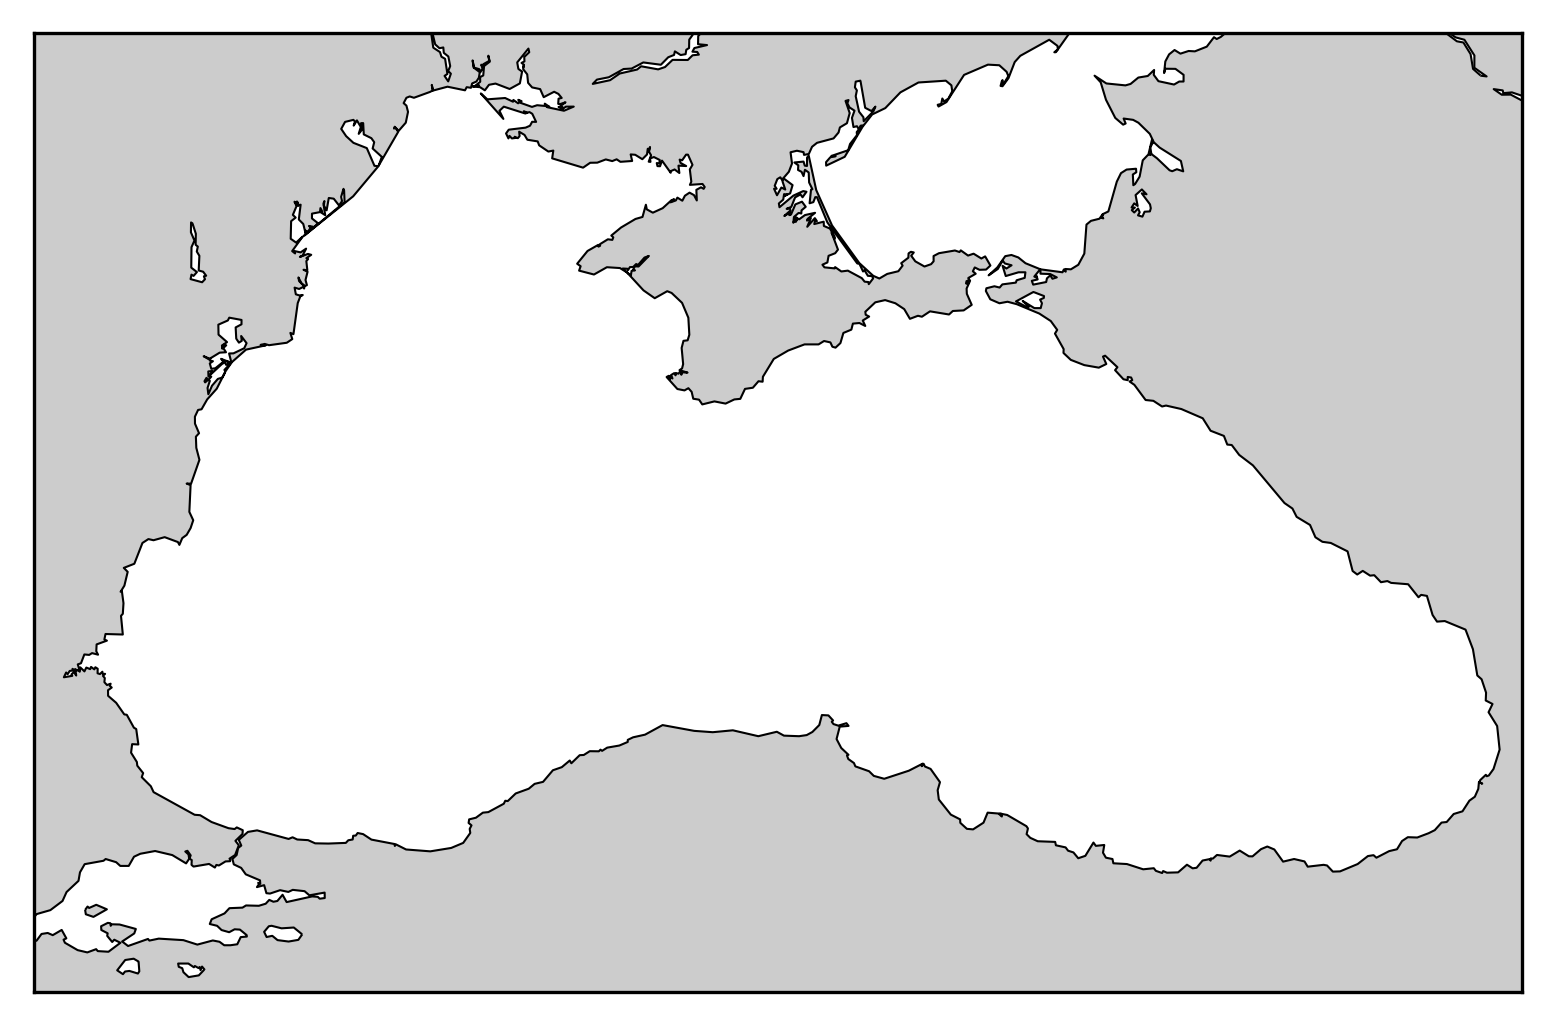

In [17]:
m[:drawcoastlines](linewidth=0.5);
m[:fillcontinents]();

## Add salinity pseudo-color plot

Convert the vectors to 2D grids: this can be done:
1. using the `repeat` function
2. using `ndgrid` provided in DIVAnd.     

In [18]:
longrid, latgrid = repeat(lon, 1, length(lat)), repeat(lat', length(lon), 1);

In [19]:
longrid2, latgrid2 = DIVAnd.ndgrid(lon, lat);

Obviously both should provide the same results.

In [20]:
@show longrid == longrid2;
@show latgrid == latgrid2;

longrid == longrid2 = true
latgrid == latgrid2 = true


We can now use all of the [`matplotlib basemap`](https://matplotlib.org/basemap/) functions, for example:

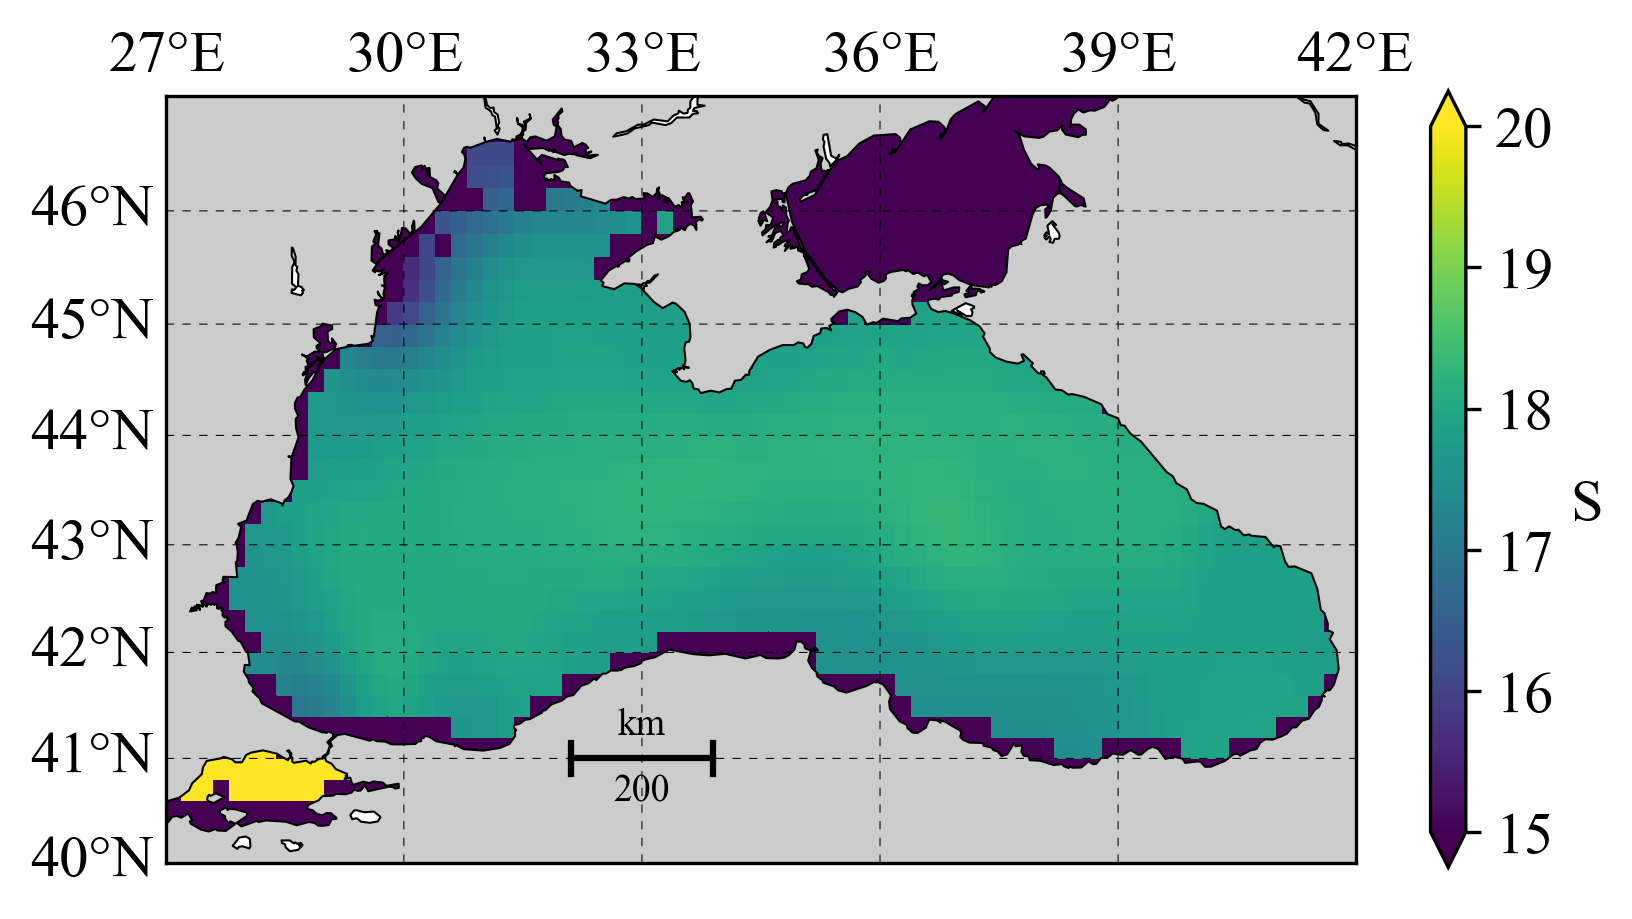

In [21]:
pcm = m[:pcolormesh](longrid, latgrid, salinityplot, latlon="True", vmin=15., vmax=20.);
m[:drawmeridians](collect(27:3:42), linewidth=.25, labels=(0,0,1,0))
m[:drawparallels](collect(40:1:48), linewidth=.25, labels=(1,0,0,0))
m[:drawmapscale](33., 41., 33., 41., length=200, barstyle="simple", units="km")
m[:drawcoastlines](linewidth=0.5)
m[:fillcontinents]();
cb = colorbar(pcm, shrink=0.7, extend="both")
cb.set_label("S", rotation=0, ha="left")
show()

### Plotting the land-sea mask
One can also use the bathymetry to display the land-sea mask, instead of calling `fillcontinents` and `drawcoastlines`.

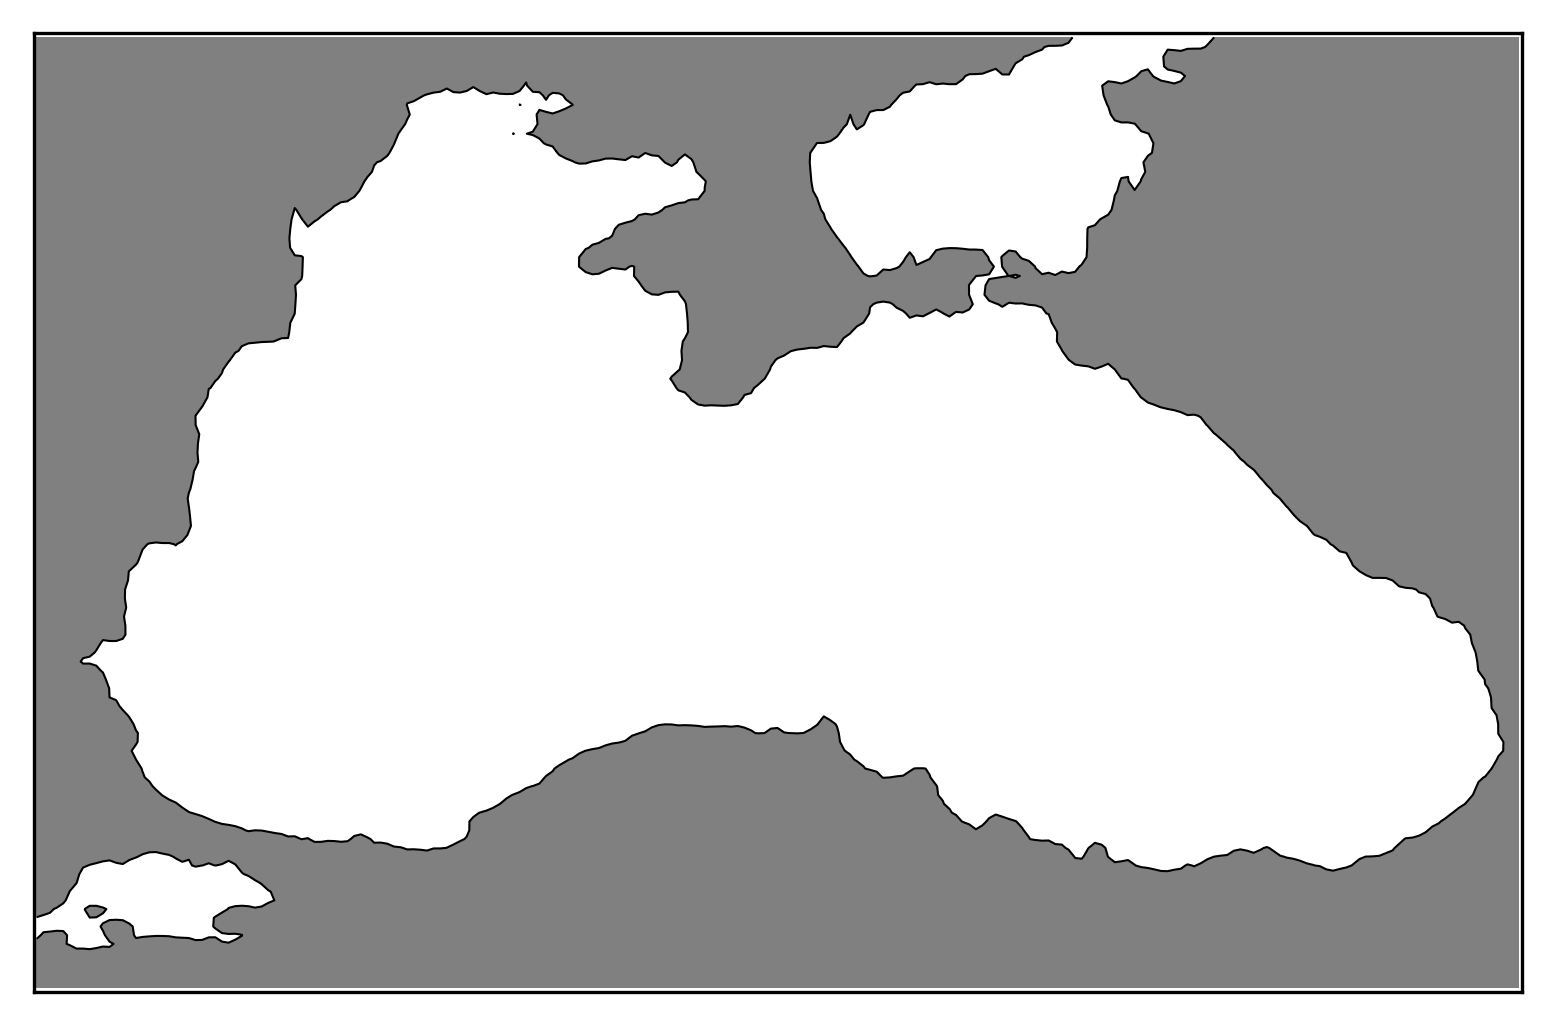

PyObject <matplotlib.contour.QuadContourSet object at 0x7fdb23b78438>

In [22]:
m[:contourf](bxx, byy, b, latlon=true, levels = [-1e5,0], colors = [[.5,.5,.5]])
m[:contour](bxx, byy, b, latlon=true, levels = [0], colors = ["black"], linewidths=.5)